# Flexible Smart Simulation 

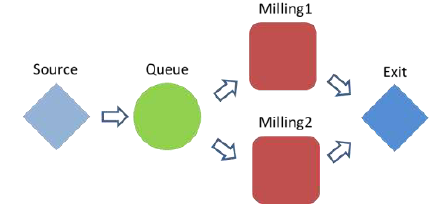

MIT License

Copyright (c) 2022, S.M.E.Sharifnia (ssharifn@tennessee.edu), @CASRE; The University of Tennessee, Knoxville.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [2]:
# The simulation main class

import numpy as np
import pandas as pd

class main_model:
    
    def __init__(self):
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from manpy.simulation.imports import Machine, Source, Exit, Part, Queue, Failure, Repairman
        from manpy.simulation.Globals import runSimulation
        
#         self.machines = int(input("Number of stations: "))
        
        self.df = pd.read_excel('Smart_Simulation_inputs_V.0.2.xlsx',sheet_name='TIMES', skiprows=2)
        self.stations = self.df['WorkStationIndex'].unique()
        
        self.df = self.df.sort_values(by=['WorkStationIndex'])
        
        prompt = True
        while prompt:
            self.series_type = input(f"Is it a 1-piece-flow line?(y/n):")
            if self.series_type != 'y' and self.series_type != 'n':
                print("Sorry! your input must be (y/n), try again:")
            else:
                prompt = False
        
        index = []
        for i in self.df["WorkStationIndex"].unique():
            for j in range(self.df["WorkStationIndex"].value_counts()[i]):
                index1 = j + 1
                index.append(index1)

        self.df["MachineIndex"] = index
        self.df.set_index('MachineIndex').reset_index()
        
        self.machines = {}
        self.MeanT = {}
        self.StdT = {}
        self.MTTF = {}
        self.Std_TTF = {}
        self.MTTR = {}
        self.Std_TTR = {}
        for i in self.df["WorkStationIndex"].unique():
            self.machines[i] = list(self.df.loc[(self.df["WorkStationIndex"] == i)]["MachineIndex"])
            for j in self.df.loc[self.df["WorkStationIndex"] == i]["MachineIndex"]:
                self.MeanT[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] == i) & (self.df["MachineIndex"] == j)]["ProcessTimeMEAN"])
                self.StdT[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] == i) & (self.df["MachineIndex"] == j)]["ProcessTimeSTD"])
                self.MTTF[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] == i) & (self.df["MachineIndex"] == j)]["MTTF_valid"])
                self.Std_TTF[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] == i) & (self.df["MachineIndex"] == j)]["STDTTF_valid"])
                self.MTTR[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] == i) & (self.df["MachineIndex"] == j)]["MTTR_valid"])
                self.Std_TTR[i,j] = float(self.df.loc[(self.df["WorkStationIndex"] ==i) & (self.df["MachineIndex"] == j)]["STDTTR_valid"])
                    
#         self.MaxW = int(input("Maximum Number of workers in the System: "))

        # df = pd.DataFrame(data,index=["MeanTimes", "StdTimes", "MTTF", "StdTTF", "MTTR", "StdTTR"])
#         self.df = pd.DataFrame({"MeanTimes": MeanT, "StdTimes":StdT, "MTTF":MTTF, "StdTTF":Std_TTF, "MTTR":MTTR, "StdTTR":Std_TTR})
        
        for i in self.stations:
            print("Machines in Station {}: {}".format(i, self.machines[i]))
            
        ############################################################################################    
        

## Adding Simulation function to the Main class:

def sim(self, runtime): 
    import matplotlib.pyplot as plt
    from manpy.simulation.imports import Machine, Source, Exit, Part, Queue, Failure, Repairman
    from manpy.simulation.Globals import runSimulation

    S=Source('S','Source', interArrivalTime={'Fixed':{'mean':1.5}}, entity='manpy.Part')

    M = {}
    F = {}    

    for i in self.stations:
        for j in self.machines[i]:
            M[i,j] = Machine("M{}".format(i,j),"Milling{}".format(i,j), 
                             processingTime={'Normal':{'mean':self.MeanT[i,j],'stdev':self.StdT[i,j],'min':0.1,'max':10e7}})
            F[i,j] = Failure(victim=M[i,j],distribution={'TTF':{'Normal':{'mean':self.MTTF[i,j],'stdev':self.Std_TTF[i,j],'min':0.1,'max':10e7}},\
                                                         'TTR':{'Normal':{'mean':self.MTTR[i,j],'stdev':self.Std_TTR[i,j],'min':0.1,'max':10e7}}})

#         Q = {}
#         for i in range(self.stations):
#             Q[i] = Queue("Q{}".format(i),"Qiii{}".format(i))

    Q = {}
    for i in self.stations:
        if self.series_type == "y":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i))
        elif self.series_type == "n":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i), capacity=float("inf"))


    E=Exit('E','Exit')

    ##Create lists for group of machines at each station
    WS = {}
    for i in self.stations:
        MC = []
        for j in self.machines[i]:
            MC.append(M[i,j])
        WS[i] = MC

    ##############################################
    ###  Objects precedence
    #################################

    S.defineRouting([Q[min(self.stations)]])

    #Queues
    for i in self.stations:
        if i==min(self.stations):
            Q[i].defineRouting([S],WS[i])
        else :
            Q[i].defineRouting(WS[i-1],WS[i])

    #Machines  
    for i in self.stations:
        for j in self.machines[i]:
            if i != max(self.stations):
                M[i,j].defineRouting([Q[i]],[Q[i+1]])
            else:
                M[i,j].defineRouting([Q[i]],[E])

    E.defineRouting(WS[max(self.stations)])

    #Add all the objects in a list
    objectList=[S,E]

    for i in self.stations:
        objectList.append(Q[i])

    for i in self.stations:
        for j in self.machines[i]:
            objectList.append(M[i,j])
            objectList.append(F[i,j]) 


    ##############################################
    ###  Simulation settings
    #################################        

    maxSimTime=runtime  # set the length of the experiment

    # call the runSimulation giving the objects and the length of the experiment
    runSimulation(objectList, maxSimTime, seed=20)

    # calculate metrics
    working_ratio = {}
    blockage_ratio = {}
    waiting_ratio = {}

    for i in self.stations:
        for j in self.machines[i]:
            working_ratio[i,j] = float((M[i,j].totalWorkingTime/maxSimTime)*100)
            blockage_ratio[i,j] = float((M[i,j].totalBlockageTime/maxSimTime)*100)
            waiting_ratio[i,j] = float((M[i,j].totalWaitingTime/maxSimTime)*100)


    ##############################################
    ###  Simulation results
    ################################# 

    # return -(Profit)

    print("\n")
    print("Simulation Results")
    print("______________________________________________________")
    print("The system produced", E.numOfExits, "parts in", f"{E.timeLastEntityLeft: .2f}", "minutes")
    print("\n")
    print("Avg. System Lead Time: ", f"{(E.timeLastEntityLeft/int(E.numOfExits)): .2f}", "minutes")      
    print(f"System Non Value Added: {100 - (sum(working_ratio.values())/sum([len(self.machines[i]) for i in self.stations])): .2f} %")
    print(f"System Value Added: {sum(working_ratio.values())/sum([len(self.machines[i]) for i in self.stations]): .2f} %")

    print("______________________________________________________")
    print("\n")
    print("System Utilization")
    print("______________________________________________________")

    for i in self.stations:
        for j in self.machines[i]:
            print(f"The utilization of machine {i+1} is: ", f"{working_ratio[i,j]: .2f}", "%")
    print("______________________________________________________")
    print("\n")
    print("System Blockage")
    print("______________________________________________________")
    for i in self.stations:
        for j in self.machines[i]:
            print(f"The blockage of machine {i+1} is: ", f"{blockage_ratio[i,j]: .2f}", "%")
    print("______________________________________________________")
    print("\n")    
    bottleneck = []
    for i in self.stations:
        for j in self.machines[i]:
            bottleneck.append((float(self.MeanT[i,j])*maxSimTime)/(maxSimTime-M[i,j].totalFailureTime))

    print("Bottleneck Station:", f"Machine {bottleneck.index(max(bottleneck))+1}")
#     Style.BRIGHT + Fore.RED +
#     Style.RESET_ALL

    print("______________________________________________________")
#     for i in range(machines):
#         print(f"Machine {i+1} has an avg cycle time of : {float(MeanT[i])*maxSimTime/(maxSimTime-M[i].totalFailureTime): .2f} minutes")
    print("\n")

    #Cycle Time Analysis per Machine
    names_machines = []
    values = []
    for i in self.stations:
        for j in self.machines[i]:
            names_machines.append(f"M{i,j}")
            values.append(float(self.MeanT[i,j])*maxSimTime/(maxSimTime-M[i,j].totalFailureTime))

    plt.bar(names_machines, values)
    plt.suptitle('Machines Cycle Time')
    plt.xticks(rotation='vertical')
    plt.ylabel('Time')
    plt.show()        

#     ##############################################
#     ###  WIP analysis
#     ##############################################
#     Q_level_list={}
#     Q_time_list={}
#     for q in Q:
#         Q_level_list[q] = []
#         Q_time_list[q] = []
#         for i in range(len(Q[q].level_history)):
#             Q_level_list[q].append(float(Q[q].level_history[i][-1]))
#             Q_time_list[q].append(float(Q[q].level_history[i][0]))

#         plt.plot(Q_time_list[q],Q_level_list[q])
#         plt.show()

    
    ##Bottleneck Analysis per Station
    M_CT = {}
    for i in self.stations:
        ct_station = []
        for j in self.machines[i]:
            ct_station.append((float(self.MeanT[i,j])*maxSimTime)/(maxSimTime-M[i,j].totalFailureTime))
        M_CT[i] = ct_station

    self.S_CT = []
    for i in self.stations:
        self.S_CT.append(sum(M_CT[i])/len(self.machines[i]))

    names_stations = []
    for i in self.stations:
        names_stations.append(f"Station {i}")

    plt.bar(names_stations, self.S_CT)
    plt.suptitle('Station Avg. Cycle Time')
    plt.ylabel('Time')
    plt.xticks(rotation='vertical')
    plt.show()

    self.BN_station_index = self.S_CT.index(max(self.S_CT))+1
    print("Bottleneck Station:", f"Station {self.BN_station_index}")

    return(self.BN_station_index)
    #         return {'NumProduced':int(E.numOfExits), 'working_ratio':working_ratio.values()} 
    #         return {'NumProduced':int(E.numOfExits), 'working_ratio':working_ratio}

    #         return (blockage_ratio)

    #######################################################################################################

main_model.sim = sim    

## Adding Simulation function to run multiple replications:

def sim_reps(self, runtime, reps): 
    import matplotlib.pyplot as plt
    from manpy.simulation.imports import Machine, Source, Exit, Part, Queue, Failure, Repairman
    from manpy.simulation.Globals import runSimulation

    S=Source('S','Source', interArrivalTime={'Fixed':{'mean':1.5}}, entity='manpy.Part')

    M = {}
    F = {}    

    for i in self.stations:
        for j in self.machines[i]:
            M[i,j] = Machine("M{}".format(i,j),"Milling{}".format(i,j), 
                             processingTime={'Normal':{'mean':self.MeanT[i,j],'stdev':self.StdT[i,j],'min':0.1,'max':10e7}})
            F[i,j] = Failure(victim=M[i,j],distribution={'TTF':{'Normal':{'mean':self.MTTF[i,j],'stdev':self.Std_TTF[i,j],'min':0.1,'max':10e7}},\
                                                         'TTR':{'Normal':{'mean':self.MTTR[i,j],'stdev':self.Std_TTR[i,j],'min':0.1,'max':10e7}}})

#         Q = {}
#         for i in range(self.stations):
#             Q[i] = Queue("Q{}".format(i),"Qiii{}".format(i))

    Q = {}
    for i in self.stations:
        if self.series_type == "y":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i))
        elif self.series_type == "n":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i), capacity=float("inf"))


    E=Exit('E','Exit')

    ##Create lists for group of machines at each station
    WS = {}
    for i in self.stations:
        MC = []
        for j in self.machines[i]:
            MC.append(M[i,j])
        WS[i] = MC

    ##############################################
    ###  Objects precedence
    #################################

    S.defineRouting([Q[min(self.stations)]])

    #Queues
    for i in self.stations:
        if i==min(self.stations):
            Q[i].defineRouting([S],WS[i])
        else :
            Q[i].defineRouting(WS[i-1],WS[i])

    #Machines  
    for i in self.stations:
        for j in self.machines[i]:
            if i != max(self.stations):
                M[i,j].defineRouting([Q[i]],[Q[i+1]])
            else:
                M[i,j].defineRouting([Q[i]],[E])

    E.defineRouting(WS[max(self.stations)])

    #Add all the objects in a list
    objectList=[S,E]

    for i in self.stations:
        objectList.append(Q[i])

    for i in self.stations:
        for j in self.machines[i]:
            objectList.append(M[i,j])
            objectList.append(F[i,j]) 


    ##############################################
    ###  Simulation settings
    #################################        

    maxSimTime=runtime  # set the length of the experiment

    # call the runSimulation giving the objects and the length of the experiment
    numberOfReplications = reps
    
    runSimulation(objectList, maxSimTime, numberOfReplications=numberOfReplications, seed=20)

    # calculate metrics
    working_ratio = {}
    blockage_ratio = {}
    waiting_ratio = {}

    for i in self.stations:
        for j in self.machines[i]:
            working_ratio[i,j] = float((M[i,j].totalWorkingTime/maxSimTime)*100)
            blockage_ratio[i,j] = float((M[i,j].totalBlockageTime/maxSimTime)*100)
            waiting_ratio[i,j] = float((M[i,j].totalWaitingTime/maxSimTime)*100)


    ##############################################
    ###  Simulation results
    ################################# 
    plt.plot(E.Exits)
    plt.suptitle('System Throughput in Simulation Replications')
    plt.xticks(rotation='vertical')
    plt.ylabel('Throughput')
    plt.xlabel('Replications')
    plt.show() 
    
    
    print(f"Average throughput: {np.mean(E.Exits)}")
    print(f"Standard Deviation of throughput: {np.std(E.Exits)}")
    
    return (list(E.Exits))

main_model.sim_reps = sim_reps


## Adding CV Analysis function to the Main class:

def sim_cv(self, runtime, cv):
    import matplotlib.pyplot as plt
    from manpy.simulation.imports import Machine, Source, Exit, Part, Queue, Failure, Repairman
    from manpy.simulation.Globals import runSimulation
    
    S=Source('S','Source', interArrivalTime={'Fixed':{'mean':1.5}}, entity='manpy.Part')

    M = {}
    F = {}    

    for i in self.stations:
        for j in self.machines[i]:
            M[i,j] = Machine("M{}".format(i,j),"Milling{}".format(i,j), 
                             processingTime={'Normal':{'mean':self.MeanT[i,j],'stdev': cv*self.MeanT[i,j],'min':0.1,'max':10e7}})
            F[i,j] = Failure(victim=M[i,j],distribution={'TTF':{'Normal':{'mean':self.MTTF[i,j],'stdev':self.Std_TTF[i,j],'min':0.1,'max':10e7}},\
                                                         'TTR':{'Normal':{'mean':self.MTTR[i,j],'stdev':self.Std_TTR[i,j],'min':0.1,'max':10e7}}})

#         Q = {}
#         for i in range(self.stations):
#             Q[i] = Queue("Q{}".format(i),"Qiii{}".format(i))

    Q = {}
    for i in self.stations:
        if self.series_type == "y":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i))
        elif self.series_type == "n":
            Q[i] = Queue("Q{}".format(i), "Queue{}".format(i), capacity=float("inf"))


    E=Exit('E','Exit')

    ##Create lists for group of machines at each station
    WS = {}
    for i in self.stations:
        MC = []
        for j in self.machines[i]:
            MC.append(M[i,j])
        WS[i] = MC

    ##############################################
    ###  Objects precedence
    #################################

    S.defineRouting([Q[min(self.stations)]])

    #Queues
    for i in self.stations:
        if i==min(self.stations):
            Q[i].defineRouting([S],WS[i])
        else :
            Q[i].defineRouting(WS[i-1],WS[i])

    #Machines  
    for i in self.stations:
        for j in self.machines[i]:
            if i != max(self.stations):
                M[i,j].defineRouting([Q[i]],[Q[i+1]])
            else:
                M[i,j].defineRouting([Q[i]],[E])

    E.defineRouting(WS[max(self.stations)])

    #Add all the objects in a list
    objectList=[S,E]

    for i in self.stations:
        objectList.append(Q[i])

    for i in self.stations:
        for j in self.machines[i]:
            objectList.append(M[i,j])
            objectList.append(F[i,j]) 


    ##############################################
    ###  Simulation settings
    #################################        

    maxSimTime=runtime  # set the length of the experiment

    
    # call the runSimulation giving the objects and the length of the experiment
    # run simulation
    runSimulation(objectList, maxSimTime, seed=20)

    # calculate metrics
    working_ratio = {}
    blockage_ratio = {}
    waiting_ratio = {}

    for i in self.stations:
        for j in self.machines[i]:
            working_ratio[i,j] = float((M[i,j].totalWorkingTime/maxSimTime)*100)
            blockage_ratio[i,j] = float((M[i,j].totalBlockageTime/maxSimTime)*100)
            waiting_ratio[i,j] = float((M[i,j].totalWaitingTime/maxSimTime)*100)


    #################################
    ###  Simulation results
    ################################# 
    
    return(int(E.numOfExits))

    #######################################################################################################

main_model.sim_cv = sim_cv
    

In [3]:
sys = main_model()

Is it a 1-piece-flow line?(y/n): y


Machines in Station 1: [1]
Machines in Station 2: [1]
Machines in Station 3: [1]
Machines in Station 4: [1]
Machines in Station 5: [1]
Machines in Station 6: [1]
Machines in Station 7: [1]
Machines in Station 8: [1]
Machines in Station 9: [1]


## Current State of the System:



Simulation Results
______________________________________________________
The system produced 26 parts in  467.99 minutes


Avg. System Lead Time:   18.00 minutes
System Non Value Added:  27.34 %
System Value Added:  72.66 %
______________________________________________________


System Utilization
______________________________________________________
The utilization of machine 2 is:   93.69 %
The utilization of machine 3 is:   80.97 %
The utilization of machine 4 is:   73.76 %
The utilization of machine 5 is:   77.43 %
The utilization of machine 6 is:   70.22 %
The utilization of machine 7 is:   69.37 %
The utilization of machine 8 is:   61.20 %
The utilization of machine 9 is:   65.79 %
The utilization of machine 10 is:   61.47 %
______________________________________________________


System Blockage
______________________________________________________
The blockage of machine 2 is:   6.31 %
The blockage of machine 3 is:   5.35 %
The blockage of machine 4 is:   6.43 %
The block

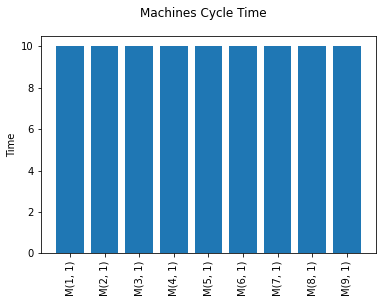

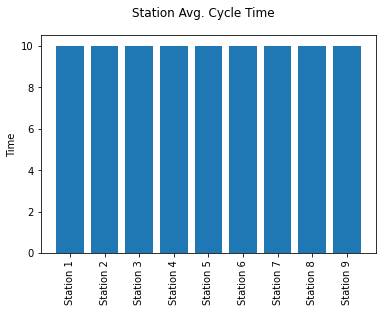

Bottleneck Station: Station 1


1

In [4]:
sys.sim(480)

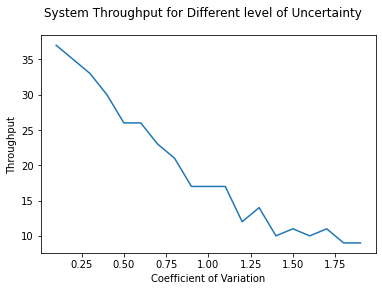

In [5]:
TH_list = []
CV_list = np.arange(0.1,2,0.1)
for cv in CV_list:
    th1 = int(sys.sim_cv(480, cv))
    TH_list.append(th1)


import matplotlib.pyplot as plt
plt.plot(CV_list,TH_list)
plt.suptitle('System Throughput for Different level of Uncertainty')
plt.ylabel('Throughput')
plt.xlabel('Coefficient of Variation')
plt.savefig('TH_plot.png', bbox_inches='tight', dpi=600)
plt.show()


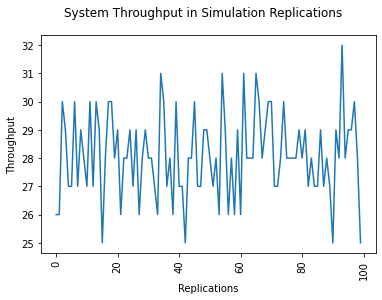

Average throughput: 28.1
Standard Deviation of throughput: 1.4866068747318504


In [6]:
TH_list2=sys.sim_reps(480,100)

In [7]:
CT_list= [(1/i)*480 for i in TH_list2]

In [45]:
np.mean(CT_list)

17.129803156675237

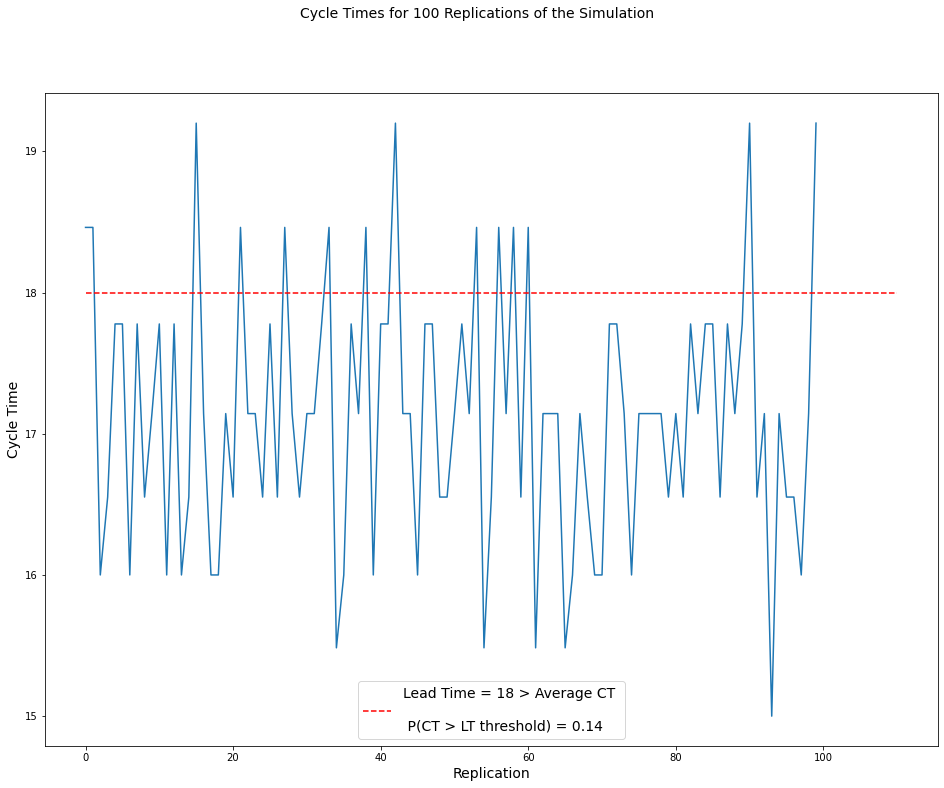

In [53]:
import matplotlib.pyplot as plt
plt.plot(CT_list)
plt.suptitle('Cycle Times for 100 Replications of the Simulation',fontsize=14)
plt.ylabel('Cycle Time',fontsize=14)
plt.xlabel('Replication',fontsize=14)
plt.savefig('TH_plot.png', bbox_inches='tight', dpi=600)

threshold1 = 18.0
plt.plot([0., 110], [threshold1, threshold1] , "k--", color="r", label = "Lead Time = 18 > Average CT \n \n P(CT > LT threshold) = 0.14")

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,10)

plt.legend(fontsize=14, loc='lower center')
plt.savefig("UB.png")
plt.show()

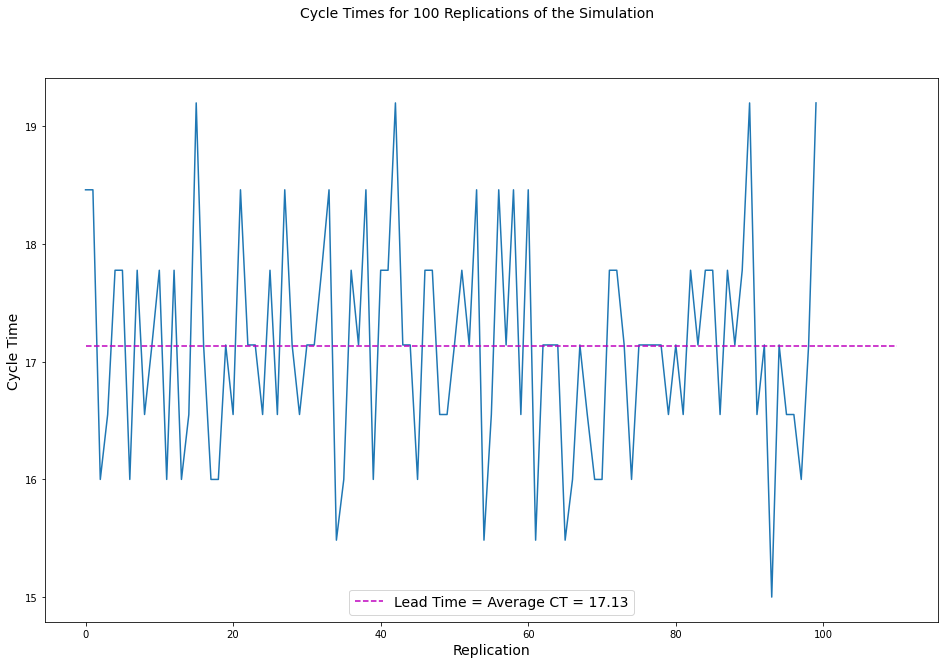

In [54]:
import matplotlib.pyplot as plt
plt.plot(CT_list)
plt.suptitle('Cycle Times for 100 Replications of the Simulation',fontsize=14)
plt.ylabel('Cycle Time',fontsize=14)
plt.xlabel('Replication',fontsize=14)
plt.savefig('TH_plot.png', bbox_inches='tight', dpi=600)

threshold1 = np.mean(CT_list)
plt.plot([0., 110], [threshold1, threshold1] , "k--", color="m", label = "Lead Time = Average CT = 17.13")
# ax.annotate('Lead Time UB',(110, 18.25), color='r', size=14)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,10)

plt.legend(fontsize=14, loc='lower center')
plt.savefig("MEAN.png")
plt.show()

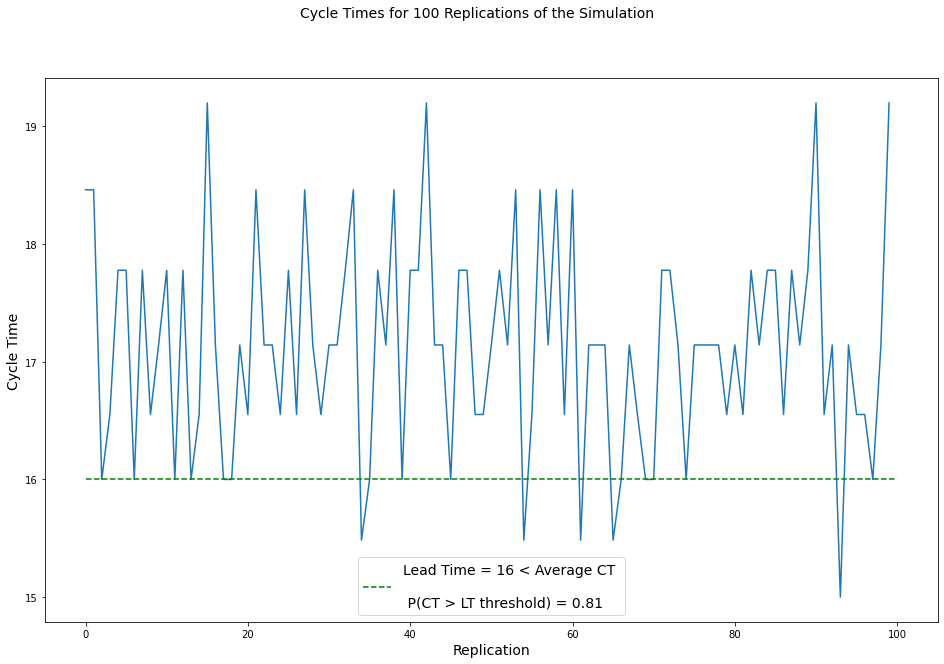

In [55]:
import matplotlib.pyplot as plt
plt.plot(CT_list)
plt.suptitle('Cycle Times for 100 Replications of the Simulation',fontsize=14)
plt.ylabel('Cycle Time',fontsize=14)
plt.xlabel('Replication',fontsize=14)
plt.savefig('TH_plot.png', bbox_inches='tight', dpi=600)

threshold2 = 16.0
plt.plot([0., 100], [threshold2, threshold2], "k--", color="g", label = "Lead Time = 16 < Average CT \n \n P(CT > LT threshold) = 0.81")

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,10)

plt.legend(fontsize=14, loc='lower center')
plt.savefig("LB.png")
plt.show()

In [34]:
data = np.array(CT_list)
threshold = 18
pr_ub = np.sum(data > threshold) / data.size
pr_ub

0.14

In [37]:
data = np.array(CT_list)
threshold = 16
pr_lb = np.sum(data > threshold) / data.size
pr_lb

0.81

In [65]:
data = np.array(CT_list)
threshold = np.median(CT_list)
pr_lb = np.sum(data == threshold) / data.size
pr_lb

0.29